              y           x         mass      size       ecc      signal  \
138  100.863354  200.520186   275.241054  1.611777  0.150182   26.498362   
212  137.171869  236.739258  1163.790979  1.608370  0.184284  108.985200   
213  139.436301  218.884589  1247.987388  1.738859  0.039683   97.445591   
217  140.821634  279.318757   742.808932  1.522747  0.130870   80.349873   
228  146.761273  205.929708   322.254278  1.475260  0.144058   36.328400   

     raw_mass        ep  frame  
138     975.0  0.048927      0  
212    4239.0  0.011139      0  
213    5048.0  0.009349      0  
217    2643.0  0.017898      0  
228    1392.0  0.034133      0  


<IPython.core.display.Javascript object>


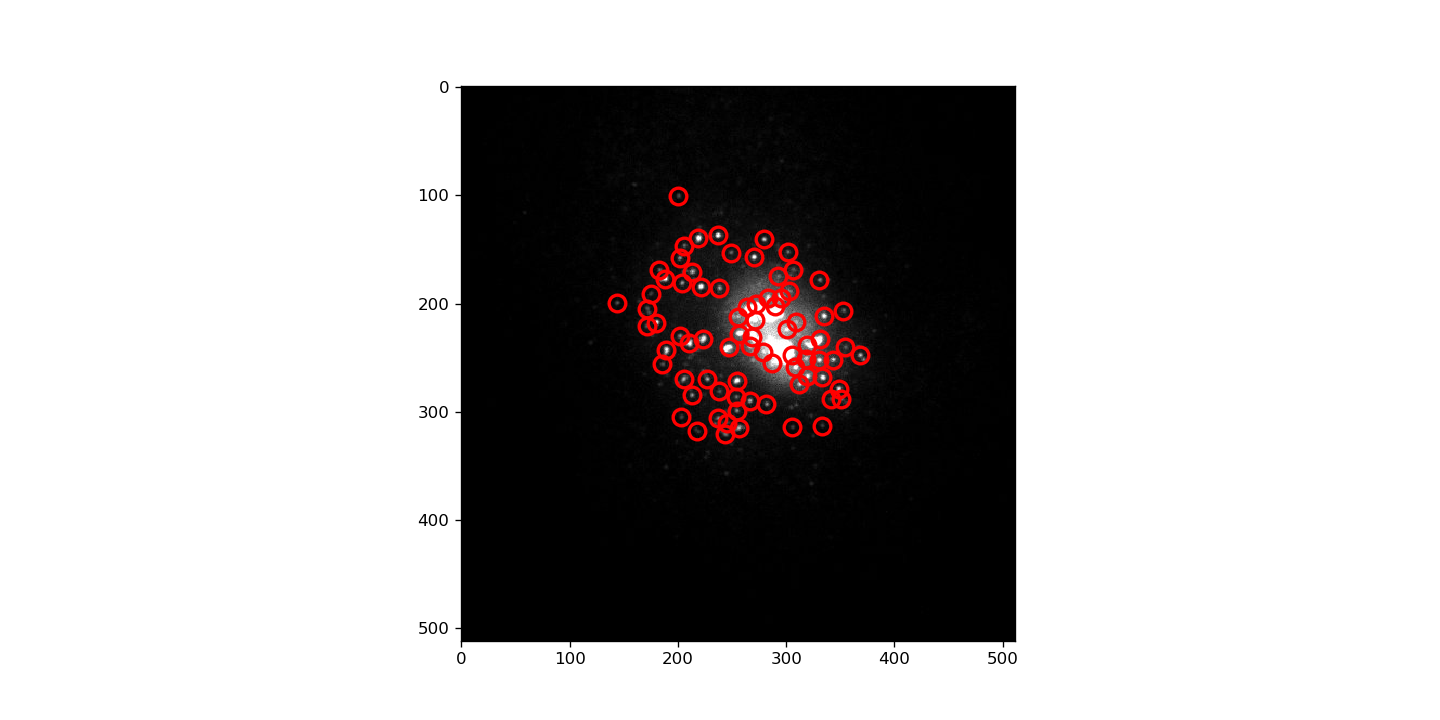

In [3]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import PIL
from sklearn.cluster import KMeans
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import factorial
from scipy.stats import poisson
from itertools import chain

import numpy
import scipy.cluster.hierarchy as hcluster

# change the following to %matplotlib notebook for interactive plotting
%matplotlib notebook
from scipy.signal import find_peaks
# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

## import images
@pims.pipeline
def gray(image):
    return image[:,:, 1]  # Take just the green channel

frames = (pims.open('T_Cell receptors/receptors_processed/*.jpg'))

f = tp.locate(frames[0],7,minmass=200)

print(f.head())  # shows the first few rows of data
tp.annotate(f, frames[0],plot_style={'markersize':10});
plt.show()
#plt.imshow(frames[0])
m_p=1
Fps=1



### function to find msd, returns list of msd values and plots the individual particles msds when called

def find_msd(data,max_lag_time):  ## takes in dataframe and a max lag time
    matrix_msd=[] ## to store all particle trajectories (each row a particle trajectory)
    d_t=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        for t in range(1,max_lag_time):  ## loop over lag times
            del_t.append(t)
            dx=[(x_list[j+t]-x_list[j]) for j in range(len(x_list)-int(max_lag_time))]
            dy=[(y_list[j+t]-y_list[j]) for j in range(len(y_list)-int(max_lag_time))]
            disp=[np.sqrt(dx[i]**2+dy[i]**2) for i in range(len(dx))] ## find displacement
            msd_temp=np.mean(disp)## mean 
            msd_part_i.append(msd_temp)
        #plt.loglog(del_t,msd_part_i,alpha=0.1,color='black')
        matrix_msd.append(msd_part_i)
        d_t.append(del_t)
        plt.xlabel('lag_time')
        plt.ylabel('msd')
        
        #plt.show() ###shows individual particle msds while calling the function
    matrix_msd_arr = np.array(matrix_msd)
    # delete all the rows with any NaN value( some rows become nan as there are too less trajectory frames compared to max lag time)
    indexList = [np.any(i) for i in np.isnan(matrix_msd_arr )]
    matrix_msd_corrected  = np.delete(matrix_msd_arr , indexList, axis=0)
    msd = np.average(matrix_msd_corrected, axis=0)  ## average columns of the matrix(ie over all positions for a lag time)
    return msd,del_t
    
def find_traj_data(frames,conect,mem,size,mass,filt):
    ## locate features in all frames( fluroscent bleach after 200 frames)
    f = tp.batch(frames[:200],size, minmass=mass); ### locate features with radius 7 and minimum brightness 100 from frame 100

    ## link different frames
    t = tp.link(f,conect, memory=mem) ### features must uptot 5 pixels in the next frame to be considered a trajectory (memory incase it disapears for some frames)

    #### trajectories that last fewer than 30 frames are disguarded
    t1 = tp.filter_stubs(t,filt)
    # Compare the number of particles in the unfiltered and filtered data.
    #print('Before:', t['particle'].nunique())
    #print('After:', t1['particle'].nunique())

     #tp.plot_traj(t1);

    ## subtract any drift in image(look at image from the center of mass)
    d = tp.compute_drift(t1)
    tm = tp.subtract_drift(t1.copy(), d) 
    tm.rename(columns = {'size':'area'}, inplace = True)
    data = pd.DataFrame()

    for item in set(tm.particle):
    
        sub = tm[tm.particle==item]
    
        dx = m_p*np.diff(sub.x)/1. # differnece between to frame for X postion
        dy = m_p*np.diff(sub.y)/1. #wdiffernece between to frame for Y postion
        dt = np.diff(sub.frame)/Fps #to calcul the time
        dr=((np.sqrt(dy**2 + dx**2)))
        tan = (dy/dx) # to calcul the slope
        ang_d=abs((np.arctan(tan)*57.2958))
        #print(np.diff(sub.frame))
        v = (((np.sqrt(dy**2 + dx**2)))/dt) # to calcul the velocity  12 microns per pixel
        for x, y, dx, dy,disp, v,ang_disp,area, dt, frame in zip(sub.x[:-1], sub.y[:-1], abs(dx), abs(dy),dr ,v,ang_d,sub.area[:-1] ,dt,sub.frame[:-1],):
            data = data.append([{'dx': dx,
            'dy': dy,
             'x': x,
             'y': y,
            'frame': frame,
             'particle': item,
              'disp':disp,                  
             'dt' : dt,
             'area':area,
              'ang_disp':ang_disp,                   
             'v' : v,}])
       
    ## correct angles based on a cartesian plane convert to radian
    ang_list=list(data['ang_disp'])
    dx_list=list(data['x'])
    dy_list=list(data['y'])
    #print(dx_list)
    #69.123*0.0174533
    ang_d_corrected=[]  
    for i in range(0,len(ang_list)):
        if dx_list[i]>0 and dy_list[i]>0:
            ang_d_corrected.append((ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]>0:
            ang_d_corrected.append((180-ang_list[i])*0.0174533)
        if dx_list[i]<0 and dy_list[i]<0:
            ang_d_corrected.append((180+ang_list[i])*0.0174533)
        if dx_list[i]>0 and dy_list[i]<0:
            ang_d_corrected.append(((360-ang_list[i])*0.0174533))
    data['ang_corr']=ang_d_corrected
    
    utraj = np.unique(tm.particle)
    num_traj = utraj.size
    cdict = {}

   # fig, ax = plt.subplots(figsize=(8,8))
   # ax.cla()
    #for i in range(num_traj):
    #    iid = tm.particle == utraj[i]
    #    xi = np.array(tm.x[iid])
     #   yi = np.array(tm.y[iid])
        # print(xi.shape)
    
      #  if (xi.size > 0):
      #      plt.plot(xi,yi,'-',ms=2,lw=0.5)
       #     p = ax.plot(xi,yi,'-',ms=2,lw=0.5)
         #   color = p[0].get_color()
         #   cdict[utraj[i]] = color 
          #  plt.plot(xi[xi.size-1],yi[xi.size-1],'o',ms=4,c=color,markerfacecolor='w',lw=0.5)
    return tm,data
      

In [2]:
%matplotlib notebook
def find_ee_distance(data):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    xi=[]
    yi=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dx=(x_list[0]-x_list[-1])
        dy=(y_list[0]-y_list[-1])
        disp=np.sqrt(dx**2+dy**2) ## find displacement
        disp_part_i.append(disp)
        xi.append(x_list[-1])
        yi.append(y_list[-1])
        part_id.append(i)
    return disp_part_i,xi,yi,part_id

def find_rad_distance(data,xc,yc):  ## takes in dataframe and a max lag time
    disp_part_i=[]
    ri_list=[]
    rf_list=[]
    part_id=[]
    ## see all particle numbers that have trajectory 
    part_temp=list(data['particle'])
    part = list(set(part_temp))
    for i in part: ## loop over all trajectories
        del_t=[]
        msd_part_i=[]
        df=data.loc[data['particle'] ==i]  ## dataframe of all rows with particle =i
        x_list=list(df['x'])## x positions of particle i
        y_list=list(df['y'])## y positions of particle i
        dxi=(x_list[0]-xc)
        dyi=(y_list[0]-yc)
        dxf=(x_list[-1]-xc)
        dyf=(y_list[-1]-yc)  
        ri=np.sqrt(dxi**2+dyi**2) ## find displacement
        rf=np.sqrt(dxf**2+dyf**2) ## find displacement
        ri_list.append(ri)
        rf_list.append(rf)
        part_id.append(i)
    return ri_list,rf_list,part_id

def in_out(min_dist,ri,rf,xe,ye,ee,iidr,data,frames):
    iid_in=[]
    iid_out=[]
    for i in range(0,len(ri)):
        
        if ri[i]>rf[i] and ee[i]>min_dist:
            plt.scatter(xe[i],ye[i],color='yellow',s=20)
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            plt.plot(trajx,trajy,color='brown')
            iid_in.append(i)
        if ri[i]<rf[i] and ee[i]>min_dist:
            plt.scatter(xe[i],ye[i],color='cyan',s=20)
            df=data.loc[data['particle'] ==iidr[i]]
            trajx=df['x'].tolist()
            trajy=df['y'].tolist()
            plt.plot(trajx,trajy,color='brown')
            iid_out.append(i)
         #plt.ylim(max(ye), min(ye))

    plt.plot()
    plt.imshow(frames[0]);
    ratio_in_out=len(iid_in)/(len(iid_out)+len(iid_in))
    
    return ratio_in_out

def find_cm(frames,tm):
    ##finding center of cell, is taking center of mass ok? how to define the center from image?
    f = tp.batch(frames[:200],size, minmass=70); ### locate features with radius 7 and minimum brightness 100 from frame 100
    x_vals=f['x'].tolist()
    y_vals=f['y'].tolist()
    mass=f['raw_mass'].tolist()
    x_cm=0
    y_cm=0
    for i in range(0,len(mass)):## takin
        x_cm+=(x_vals[i]*mass[i])/np.sum(mass)
        y_cm+=(y_vals[i]*mass[i])/np.sum(mass)
    
     
    return x_cm,y_cm


In [3]:
%matplotlib notebook
conect=2
mem=3
size=5
mass=200
filt=9
ratio_list=[]
msd_list=[]
msd_list2=[]
dt_list=[]
for i in range(1,2):
    framesMwt = (pims.open('T_Cell receptors/mouse_wt%d/*.jpg'%i))
    
    tmMwt,dataMwt=find_traj_data(framesMwt,conect,mem,size,mass,filt)
    msd_Mwt,dt_Mwt=find_msd(tmMwt,40)
    em = tp.emsd(tmMwt,1, 1)
    eeMwt,xeMwt,yeMwt,iidMwt=find_ee_distance(tmMwt)
    x_cm,y_cm=find_cm(framesMwt,tmMwt)
    riMwt,rfMwt,iidrMwt=find_rad_distance(tmMwt,x_cm,y_cm)
    ratioMwt=in_out(1,riMwt,rfMwt,xeMwt,yeMwt,eeMwt,iidrMwt,dataMwt,framesMwt)  
    ratio_list.append(ratioMwt)
    msd_list.append(em)
    msd_list2.append(msd_Mwt)
    dt_list.append(dt_Mwt)

Frame 199: 6 features


In [23]:
print('ratios',ratio_list)

ratios [0.5, 0.7647058823529411, 0.6190476190476191, 0.725, 0.5833333333333334, 0.5, 0.5952380952380952]


In [4]:
%matplotlib notebook
framesMwt = (pims.open('T_Cell receptors/mouse_wt1/*.jpg'))
    
tmMwt,dataMwt=find_traj_data(framesMwt,conect,mem,size,mass,filt)
msd_Mwt,dt_Mwt=find_msd(tmMwt,40)
em = tp.emsd(tmMwt,1, 1)
eeMwt,xeMwt,yeMwt,iidMwt=find_ee_distance(tmMwt)
x_cm,y_cm=find_cm(framesMwt,tmMwt)
riMwt,rfMwt,iidrMwt=find_rad_distance(tmMwt,x_cm,y_cm)
ratioMwt=in_out(1,riMwt,rfMwt,xeMwt,yeMwt,eeMwt,iidrMwt,dataMwt,framesMwt)  
ratio_list.append(ratioMwt)
plt.show()

Frame 199: 6 features


<IPython.core.display.Javascript object>


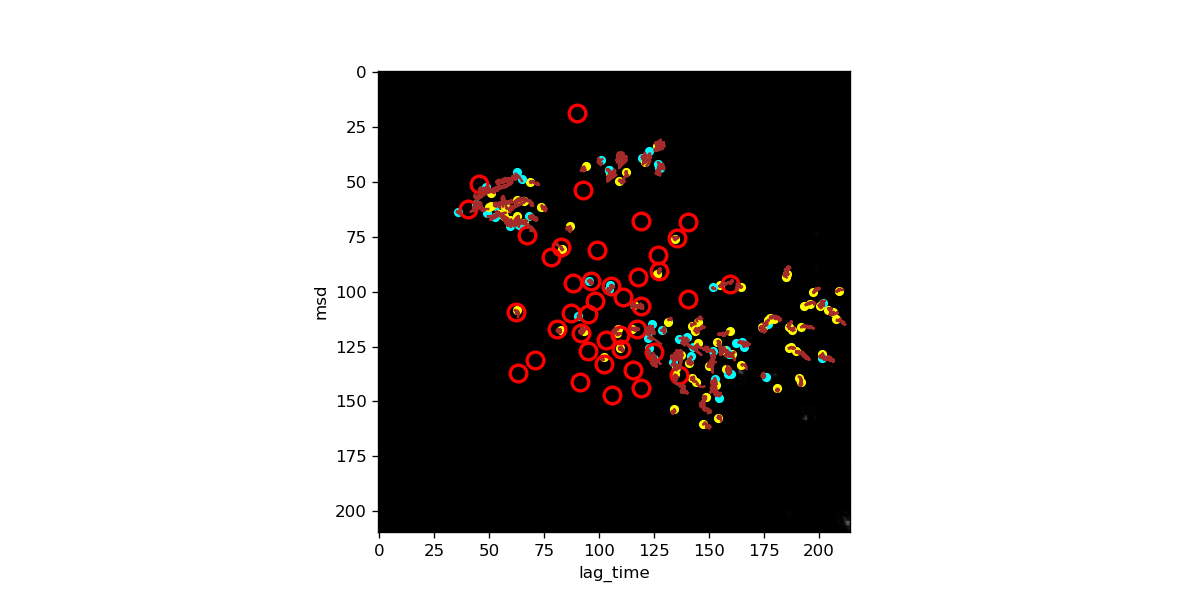

In [7]:
%matplotlib notebook
@pims.pipeline
def gray(image):
    return image[:,:, 1]  # Take just the green channel

framesMwt = (pims.open('T_Cell receptors/mouse_wt2/*.jpg'))

conect=2
mem=3
size=5
mass=100
filt=9
#tmMwt,dataMwt=find_traj_data(framesMwt,conect,mem,size,mass,filt)
#msd_Mwt,dt_Mwt=find_msd(tmMwt,40)
n=10
f = tp.locate(framesMwt[n],size,minmass=mass)
tp.annotate(f, framesMwt[n],plot_style={'markersize':10});
plt.show()

<IPython.core.display.Javascript object>


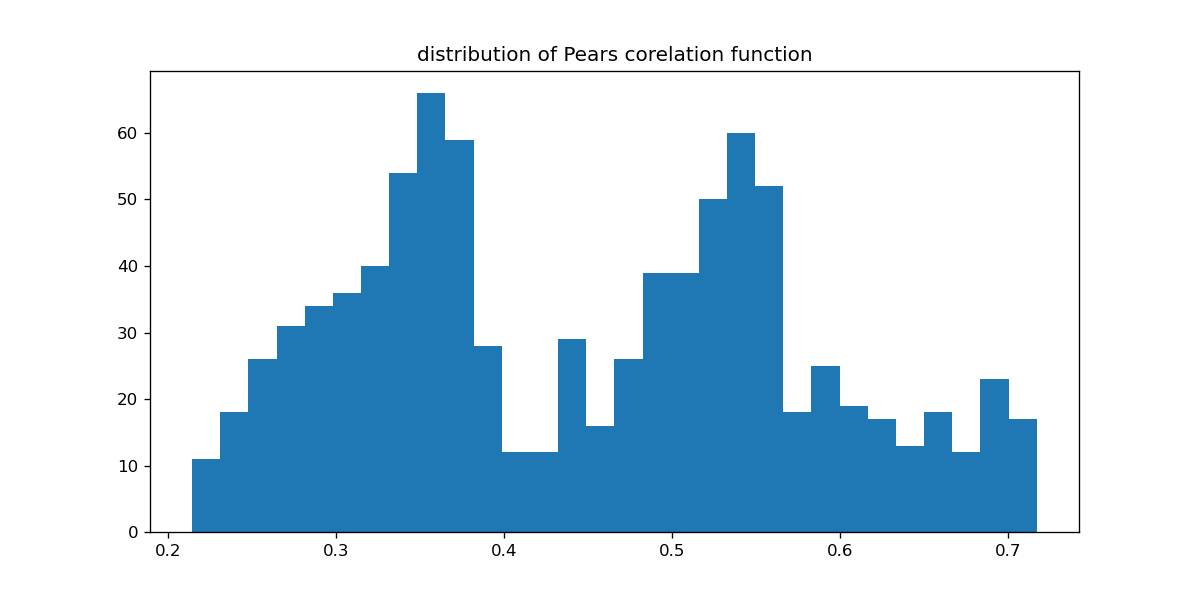

mean PCC


In [25]:
frames1 = (pims.open('actin2/*.jpg'))
frames_ac = (pims.open('recept2/*.jpg'))
from scipy.stats import pearsonr
%matplotlib notebook
PC=[]
for i in range(len(frames1)):
   
    image1_flat = frames1[i].flatten()
    image2_flat = frames_ac[i].flatten()
    # Calculate the Pearson correlation coefficient between the two images
    corr_coef, _ = pearsonr(image1_flat, image2_flat)
    PC.append(corr_coef)

plt.hist(PC,30)
plt.title('distribution of Pears corelation function')
print('mean PCC',)


<IPython.core.display.Javascript object>


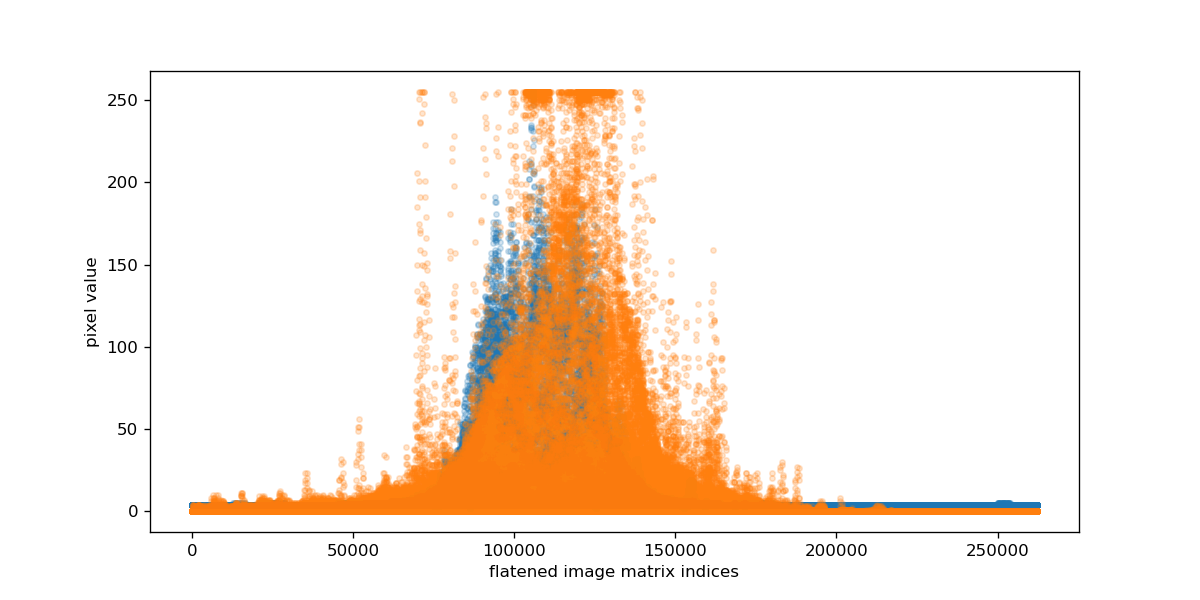

Text(0, 0.5, 'pixel value')

In [24]:
%matplotlib notebook
for i in range(1):
    
    image1_flat = frames1[i].flatten()
    image2_flat = frames_ac[i].flatten()
    x=np.arange(0,len(image1_flat),1)
    plt.scatter(x,image1_flat,s=10,alpha=0.2)
    plt.scatter(x,image2_flat,s=10,alpha=0.2)
plt.xlabel('flatened image matrix indices')
plt.ylabel('pixel value')

<IPython.core.display.Javascript object>


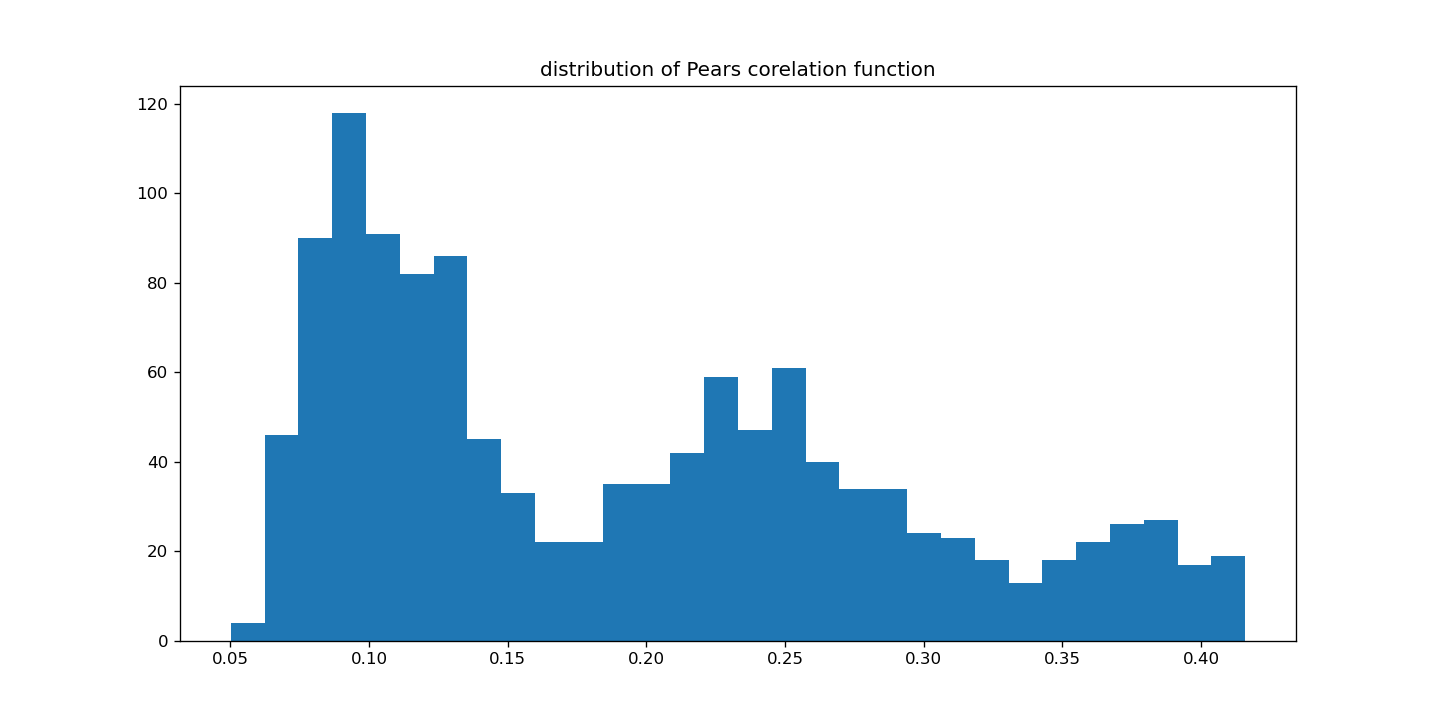

mean PCC


In [26]:
frames1 = (pims.open('Jactin/*.jpg'))
frames_ac = (pims.open('Jrecept/*.jpg'))
from scipy.stats import pearsonr
%matplotlib notebook
PC=[]
for i in range(len(frames1)):
   
    image1_flat = frames1[i].flatten()
    image2_flat = frames_ac[i].flatten()
    # Calculate the Pearson correlation coefficient between the two images
    corr_coef, _ = pearsonr(image1_flat, image2_flat)
    PC.append(corr_coef)

plt.hist(PC,30)
plt.title('distribution of Pears corelation function')


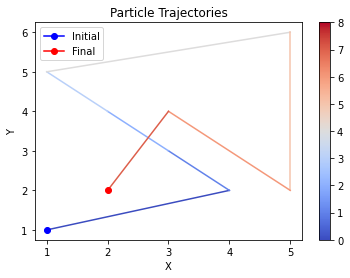

In [2]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 4, 3, 2, 1, 5, 5, 3, 2]
y = [1, 2, 3, 4, 5, 6, 2, 4, 2]

# Define the colormap
cmap = plt.cm.get_cmap('coolwarm')

# Normalize the color values between 0 and 1
norm = plt.Normalize(0, len(x) - 1)

# Plot the trajectories with a colormap
for i in range(len(x) - 1):
    color = cmap(norm(i))
    plt.plot([x[i], x[i+1]], [y[i], y[i+1]], color=color)

# Plot the initial and final points as blue and red, respectively
plt.plot(x[0], y[0], marker='o', color='blue', label='Initial')
plt.plot(x[-1], y[-1], marker='o', color='red', label='Final')

# Add a colorbar to show the fade in between
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)

# Set labels and title
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Particle Trajectories')

# Add a legend
plt.legend()

# Show the plot
plt.show()